#### Saturday, February 14, 2026

This all runs in one pass.

# 03 - Technical Strategy: Build, Backtest & Evaluate

**The most important notebook in this series.** Before you ever risk real money,
you need to test your strategy on historical data.

---

## What You'll Build

1. **Backtesting Engine** - A reusable framework from scratch (no black-box libraries)
2. **5 Day Trading Strategies** - Each with clear entry/exit rules
   - EMA Crossover (trend following)
   - RSI Mean Reversion (counter-trend)
   - VWAP Bounce (institutional level)
   - Opening Range Breakout (volatility)
   - Bollinger Band Squeeze (consolidation breakout)
3. **Performance Metrics** - Sharpe ratio, max drawdown, profit factor, win rate
4. **Strategy Comparison** - Head-to-head tournament across multiple stocks
5. **Walk-Forward Analysis** - The RIGHT way to validate a strategy
6. **Risk-Adjusted Position Sizing** - ATR-based stops and dynamic sizing
7. **Pitfalls & Biases** - How NOT to fool yourself

---

## Why Backtesting Matters

- **70-90% of day traders lose money** -- most never backtest
- A strategy that "looks good" on a chart may fail statistically
- Backtesting reveals the REAL win rate, drawdowns, and edge (or lack thereof)
- It builds confidence: you know what to expect in live trading
- It prevents emotional decisions: your rules are defined in advance

---
## 1. Setup & Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from ta.trend import EMAIndicator, SMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
from dataclasses import dataclass, field
from typing import Optional
import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
sns.set_palette('bright')

print("Imports ready.")

Imports ready.


In [2]:
# Fetch historical data for backtesting
# We want enough data for meaningful results but not so much that market regimes change completely

TICKERS = ['NVDA', 'AAPL', 'TSLA', 'AMD', 'MSFT', 'META', 'SPY']

# Daily data -- 2 years for robust backtesting
daily_data = {}
for ticker in TICKERS:
    df = yf.download(ticker, period='2y', interval='1d', progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    daily_data[ticker] = df
    print(f"{ticker}: {len(df)} trading days | "
          f"${df['Close'].iloc[0]:.2f} -> ${df['Close'].iloc[-1]:.2f} "
          f"({(df['Close'].iloc[-1]/df['Close'].iloc[0]-1)*100:+.1f}%)")

# Intraday data -- for intraday strategy testing (limited to ~60 days from yfinance)
print("\nFetching intraday data (5-min bars)...")
intraday_data = {}
for ticker in ['NVDA', 'TSLA', 'SPY']:
    df = yf.download(ticker, period='60d', interval='5m', progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    intraday_data[ticker] = df
    print(f"{ticker}: {len(df)} bars ({len(df)//78} approx trading days of 5-min bars)")

NVDA: 502 trading days | $73.86 -> $182.81 (+147.5%)
AAPL: 502 trading days | $182.49 -> $255.78 (+40.2%)
TSLA: 502 trading days | $188.71 -> $417.44 (+121.2%)
AMD: 502 trading days | $178.70 -> $207.32 (+16.0%)
MSFT: 502 trading days | $404.22 -> $401.32 (-0.7%)
META: 502 trading days | $470.00 -> $639.77 (+36.1%)
SPY: 502 trading days | $486.54 -> $681.75 (+40.1%)

Fetching intraday data (5-min bars)...
NVDA: 4483 bars (57 approx trading days of 5-min bars)
TSLA: 4485 bars (57 approx trading days of 5-min bars)
SPY: 4482 bars (57 approx trading days of 5-min bars)


---
## 2. The Backtesting Engine

We build our own engine so you understand exactly what's happening.
No hidden assumptions, no magic.

### Design Principles
- **No look-ahead bias**: Decisions only use data available at the time
- **Realistic fills**: We enter at the NEXT bar's open, not the signal bar's close
- **Commission & slippage**: Included by default
- **Position sizing**: Based on risk, not fixed dollar amounts

In [3]:
@dataclass
class Trade:
    """Record of a single completed trade."""
    entry_date: pd.Timestamp
    exit_date: pd.Timestamp
    direction: str          # 'long' or 'short'
    entry_price: float
    exit_price: float
    shares: int
    pnl: float              # profit/loss in dollars
    pnl_pct: float          # profit/loss as percentage
    exit_reason: str        # 'stop_loss', 'take_profit', 'signal', 'end_of_day'
    bars_held: int


@dataclass
class Position:
    """An open position."""
    direction: str
    entry_date: pd.Timestamp
    entry_price: float
    shares: int
    stop_loss: float
    take_profit: Optional[float] = None
    bars_held: int = 0


class BacktestEngine:
    """
    Event-driven backtesting engine.
    
    Walks through bars one at a time, calling the strategy for signals.
    Handles position management, stop losses, and performance tracking.
    """
    
    def __init__(self, initial_capital=25000, commission=0.00,
                 slippage_pct=0.0005, risk_per_trade_pct=1.0):
        self.initial_capital = initial_capital
        self.commission = commission           # per-share commission
        self.slippage_pct = slippage_pct       # 0.05% slippage per trade
        self.risk_per_trade_pct = risk_per_trade_pct
    
    def run(self, df, strategy_fn, verbose=False):
        """
        Run a backtest.
        
        Parameters:
            df: DataFrame with OHLCV + any indicators the strategy needs
            strategy_fn: function(df, i, position) -> signal dict or None
                signal dict: {'action': 'buy'/'sell'/'close', 'stop_loss': float, 'take_profit': float}
            verbose: print each trade
        
        Returns:
            results dict with trades, equity curve, metrics
        """
        capital = self.initial_capital
        position = None
        trades = []
        equity_curve = []
        
        for i in range(1, len(df)):
            current_bar = df.iloc[i]
            prev_bar = df.iloc[i - 1]
            date = df.index[i]
            
            # Track equity (capital + unrealized P&L)
            unrealized = 0
            if position:
                position.bars_held += 1
                if position.direction == 'long':
                    unrealized = (current_bar['Close'] - position.entry_price) * position.shares
                else:
                    unrealized = (position.entry_price - current_bar['Close']) * position.shares
            
            equity_curve.append({
                'date': date,
                'equity': capital + unrealized,
                'capital': capital,
                'position': position.direction if position else 'flat',
            })
            
            # Check stop loss / take profit FIRST (before new signals)
            if position:
                closed = False
                exit_price = None
                exit_reason = None
                
                if position.direction == 'long':
                    if current_bar['Low'] <= position.stop_loss:
                        exit_price = position.stop_loss
                        exit_reason = 'stop_loss'
                        closed = True
                    elif position.take_profit and current_bar['High'] >= position.take_profit:
                        exit_price = position.take_profit
                        exit_reason = 'take_profit'
                        closed = True
                else:  # short
                    if current_bar['High'] >= position.stop_loss:
                        exit_price = position.stop_loss
                        exit_reason = 'stop_loss'
                        closed = True
                    elif position.take_profit and current_bar['Low'] <= position.take_profit:
                        exit_price = position.take_profit
                        exit_reason = 'take_profit'
                        closed = True
                
                if closed:
                    trade = self._close_position(position, exit_price, date, exit_reason)
                    capital += trade.pnl
                    trades.append(trade)
                    if verbose:
                        self._print_trade(trade)
                    position = None
            
            # Get strategy signal (using data up to PREVIOUS bar to avoid look-ahead)
            signal = strategy_fn(df, i - 1, position)
            
            if signal is None:
                continue
            
            action = signal.get('action')
            
            # Close existing position on signal
            if action == 'close' and position:
                exit_price = current_bar['Open'] * (1 - self.slippage_pct if position.direction == 'long'
                                                     else 1 + self.slippage_pct)
                trade = self._close_position(position, exit_price, date, 'signal')
                capital += trade.pnl
                trades.append(trade)
                if verbose:
                    self._print_trade(trade)
                position = None
            
            # Open new position
            if action in ('buy', 'sell') and position is None:
                entry_price = current_bar['Open'] * (1 + self.slippage_pct if action == 'buy'
                                                      else 1 - self.slippage_pct)
                stop_loss = signal.get('stop_loss', 0)
                take_profit = signal.get('take_profit')
                
                # Position sizing based on risk
                risk_amount = capital * (self.risk_per_trade_pct / 100)
                risk_per_share = abs(entry_price - stop_loss)
                
                if risk_per_share > 0:
                    shares = max(1, int(risk_amount / risk_per_share))
                else:
                    shares = max(1, int(capital * 0.1 / entry_price))
                
                # Don't exceed available capital
                max_shares = int(capital * 0.95 / entry_price)
                shares = min(shares, max_shares)
                
                if shares > 0:
                    direction = 'long' if action == 'buy' else 'short'
                    position = Position(
                        direction=direction,
                        entry_date=date,
                        entry_price=entry_price,
                        shares=shares,
                        stop_loss=stop_loss,
                        take_profit=take_profit,
                    )
                    # Deduct commission
                    capital -= shares * self.commission
        
        # Close any remaining position at end
        if position:
            exit_price = df.iloc[-1]['Close']
            trade = self._close_position(position, exit_price, df.index[-1], 'end_of_test')
            capital += trade.pnl
            trades.append(trade)
        
        equity_df = pd.DataFrame(equity_curve).set_index('date')
        metrics = self._calculate_metrics(trades, equity_df)
        
        return {
            'trades': trades,
            'equity': equity_df,
            'metrics': metrics,
            'final_capital': capital,
        }
    
    def _close_position(self, position, exit_price, exit_date, reason):
        if position.direction == 'long':
            pnl = (exit_price - position.entry_price) * position.shares
        else:
            pnl = (position.entry_price - exit_price) * position.shares
        
        pnl -= position.shares * self.commission  # exit commission
        pnl_pct = pnl / (position.entry_price * position.shares) * 100
        
        return Trade(
            entry_date=position.entry_date,
            exit_date=exit_date,
            direction=position.direction,
            entry_price=position.entry_price,
            exit_price=exit_price,
            shares=position.shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            exit_reason=reason,
            bars_held=position.bars_held,
        )
    
    def _print_trade(self, trade):
        icon = '+' if trade.pnl >= 0 else '-'
        print(f"  [{icon}] {trade.direction:>5} {trade.entry_date.strftime('%Y-%m-%d')} -> "
              f"{trade.exit_date.strftime('%Y-%m-%d')} | "
              f"${trade.entry_price:.2f} -> ${trade.exit_price:.2f} | "
              f"P&L: ${trade.pnl:>+8.2f} ({trade.pnl_pct:>+6.2f}%) | {trade.exit_reason}")
    
    def _calculate_metrics(self, trades, equity_df):
        if not trades:
            return {'total_trades': 0}
        
        pnls = [t.pnl for t in trades]
        pnl_pcts = [t.pnl_pct for t in trades]
        winners = [p for p in pnls if p > 0]
        losers = [p for p in pnls if p <= 0]
        
        # Equity curve metrics
        equity = equity_df['equity']
        returns = equity.pct_change().dropna()
        
        # Max drawdown
        peak = equity.expanding().max()
        drawdown = (equity - peak) / peak
        max_dd = drawdown.min()
        
        # Sharpe ratio (annualized, assuming 252 trading days)
        if returns.std() > 0:
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
        else:
            sharpe = 0
        
        # Profit factor
        gross_profit = sum(winners) if winners else 0
        gross_loss = abs(sum(losers)) if losers else 1
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')
        
        total_return = (equity.iloc[-1] / self.initial_capital - 1) * 100
        
        return {
            'total_trades': len(trades),
            'winners': len(winners),
            'losers': len(losers),
            'win_rate': len(winners) / len(trades) * 100,
            'avg_win': np.mean(winners) if winners else 0,
            'avg_loss': np.mean(losers) if losers else 0,
            'avg_win_pct': np.mean([t.pnl_pct for t in trades if t.pnl > 0]) if winners else 0,
            'avg_loss_pct': np.mean([t.pnl_pct for t in trades if t.pnl <= 0]) if losers else 0,
            'largest_win': max(pnls),
            'largest_loss': min(pnls),
            'total_pnl': sum(pnls),
            'total_return_pct': total_return,
            'profit_factor': profit_factor,
            'sharpe_ratio': sharpe,
            'max_drawdown_pct': max_dd * 100,
            'avg_bars_held': np.mean([t.bars_held for t in trades]),
            'avg_trade_pnl': np.mean(pnls),
            'stop_loss_exits': sum(1 for t in trades if t.exit_reason == 'stop_loss'),
            'take_profit_exits': sum(1 for t in trades if t.exit_reason == 'take_profit'),
            'signal_exits': sum(1 for t in trades if t.exit_reason == 'signal'),
        }

print("BacktestEngine ready.")
print("Key features:")
print("  - Enters on NEXT bar open (no look-ahead bias)")
print("  - Includes slippage and commissions")
print("  - Risk-based position sizing")
print("  - Automatic stop loss / take profit management")
print("  - Full trade log and equity curve")

BacktestEngine ready.
Key features:
  - Enters on NEXT bar open (no look-ahead bias)
  - Includes slippage and commissions
  - Risk-based position sizing
  - Automatic stop loss / take profit management
  - Full trade log and equity curve


---
## 3. Visualization Toolkit

Reusable functions to analyze any strategy's results.

In [4]:
def print_metrics(metrics, strategy_name="Strategy"):
    """Print a formatted performance summary."""
    print(f"\n{'='*60}")
    print(f"  {strategy_name} -- Performance Summary")
    print(f"{'='*60}")
    if metrics['total_trades'] == 0:
        print("  No trades generated.")
        return
    print(f"  Total Trades:      {metrics['total_trades']}")
    print(f"  Winners/Losers:    {metrics['winners']} / {metrics['losers']}")
    print(f"  Win Rate:          {metrics['win_rate']:.1f}%")
    print(f"  Avg Win:           ${metrics['avg_win']:>+10.2f} ({metrics['avg_win_pct']:>+.2f}%)")
    print(f"  Avg Loss:          ${metrics['avg_loss']:>+10.2f} ({metrics['avg_loss_pct']:>+.2f}%)")
    print(f"  Largest Win:       ${metrics['largest_win']:>+10.2f}")
    print(f"  Largest Loss:      ${metrics['largest_loss']:>+10.2f}")
    print(f"  ---")
    print(f"  Total P&L:         ${metrics['total_pnl']:>+10.2f}")
    print(f"  Total Return:      {metrics['total_return_pct']:>+10.2f}%")
    print(f"  Profit Factor:     {metrics['profit_factor']:>10.2f}")
    print(f"  Sharpe Ratio:      {metrics['sharpe_ratio']:>10.2f}")
    print(f"  Max Drawdown:      {metrics['max_drawdown_pct']:>10.2f}%")
    print(f"  ---")
    print(f"  Avg Bars Held:     {metrics['avg_bars_held']:>10.1f}")
    print(f"  Exits: Stop={metrics['stop_loss_exits']}, "
          f"TP={metrics['take_profit_exits']}, Signal={metrics['signal_exits']}")
    
    # Quick quality assessment
    print(f"\n  Assessment:")
    if metrics['profit_factor'] > 1.5 and metrics['sharpe_ratio'] > 1.0:
        print(f"  -> Promising strategy. Worth further testing.")
    elif metrics['profit_factor'] > 1.0:
        print(f"  -> Marginal edge. Needs optimization or filtering.")
    else:
        print(f"  -> Losing strategy. Needs rework or different parameters.")


def plot_results(results, strategy_name="Strategy", ticker=""):
    """Plot equity curve, drawdown, and trade distribution."""
    equity_df = results['equity']
    trades = results['trades']
    metrics = results['metrics']
    
    if metrics['total_trades'] == 0:
        print(f"{strategy_name}: No trades to plot.")
        return
    
    fig = plt.figure(figsize=(16, 14))
    gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)
    
    title = f"{strategy_name}"
    if ticker:
        title += f" -- {ticker}"
    fig.suptitle(title, fontsize=14, y=0.98)
    
    # 1. Equity Curve
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(equity_df.index, equity_df['equity'], color='cyan', linewidth=1.5, label='Equity')
    ax1.axhline(y=results['metrics'].get('total_pnl', 0) + 25000,
                color='white', alpha=0.1)  # just for reference
    ax1.axhline(y=25000, color='yellow', linestyle='--', alpha=0.3, label='Starting Capital')
    
    # Mark trades on equity curve
    for trade in trades:
        color = 'lime' if trade.pnl > 0 else 'red'
        ax1.axvline(x=trade.entry_date, color=color, alpha=0.1, linewidth=0.5)
    
    ax1.set_ylabel('Equity ($)')
    ax1.set_title(f'Equity Curve (Return: {metrics["total_return_pct"]:+.1f}%, '
                  f'Sharpe: {metrics["sharpe_ratio"]:.2f})')
    ax1.legend(loc='upper left')
    
    # 2. Drawdown
    ax2 = fig.add_subplot(gs[1, :])
    peak = equity_df['equity'].expanding().max()
    dd = (equity_df['equity'] - peak) / peak * 100
    ax2.fill_between(dd.index, dd.values, 0, color='red', alpha=0.4)
    ax2.set_ylabel('Drawdown (%)')
    ax2.set_title(f'Drawdown (Max: {metrics["max_drawdown_pct"]:.1f}%)')
    
    # 3. Trade P&L Distribution
    ax3 = fig.add_subplot(gs[2, 0])
    pnls = [t.pnl for t in trades]
    colors = ['lime' if p > 0 else 'red' for p in pnls]
    ax3.bar(range(len(pnls)), pnls, color=colors, alpha=0.7)
    ax3.axhline(y=0, color='white', alpha=0.3)
    ax3.set_xlabel('Trade #')
    ax3.set_ylabel('P&L ($)')
    ax3.set_title(f'Individual Trade P&L ({metrics["win_rate"]:.0f}% win rate)')
    
    # 4. P&L Distribution Histogram
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.hist([t.pnl_pct for t in trades], bins=30, color='cyan', alpha=0.7, edgecolor='white', linewidth=0.5)
    ax4.axvline(x=0, color='yellow', linestyle='--', alpha=0.5)
    avg_pnl_pct = np.mean([t.pnl_pct for t in trades])
    ax4.axvline(x=avg_pnl_pct, color='lime', linestyle='--', alpha=0.7, label=f'Mean: {avg_pnl_pct:.2f}%')
    ax4.set_xlabel('Trade P&L (%)')
    ax4.set_ylabel('Count')
    ax4.set_title('P&L Distribution')
    ax4.legend()
    
    plt.show()

print("Visualization toolkit ready.")

Visualization toolkit ready.


---
## 4. Strategy #1: EMA Crossover (Trend Following)

**The idea:** When a fast EMA crosses above a slow EMA, the trend is turning bullish.
When it crosses below, the trend is turning bearish.

- **Entry (Long):** Fast EMA crosses above Slow EMA, AND price is above both EMAs
- **Entry (Short):** Fast EMA crosses below Slow EMA, AND price is below both EMAs
- **Stop Loss:** 1.5x ATR from entry
- **Take Profit:** 3x ATR from entry (2:1 reward/risk)
- **Exit:** Opposite crossover signal


  EMA Crossover -- NVDA -- Performance Summary
  Total Trades:      27
  Winners/Losers:    6 / 21
  Win Rate:          22.2%
  Avg Win:           $   +522.60 (+13.03%)
  Avg Loss:          $   -226.01 (-5.13%)
  Largest Win:       $   +931.27
  Largest Loss:      $   -258.21
  ---
  Total P&L:         $  -1610.58
  Total Return:           -6.44%
  Profit Factor:           0.66
  Sharpe Ratio:           -0.53
  Max Drawdown:          -11.16%
  ---
  Avg Bars Held:            6.3
  Exits: Stop=18, TP=6, Signal=2

  Assessment:
  -> Losing strategy. Needs rework or different parameters.


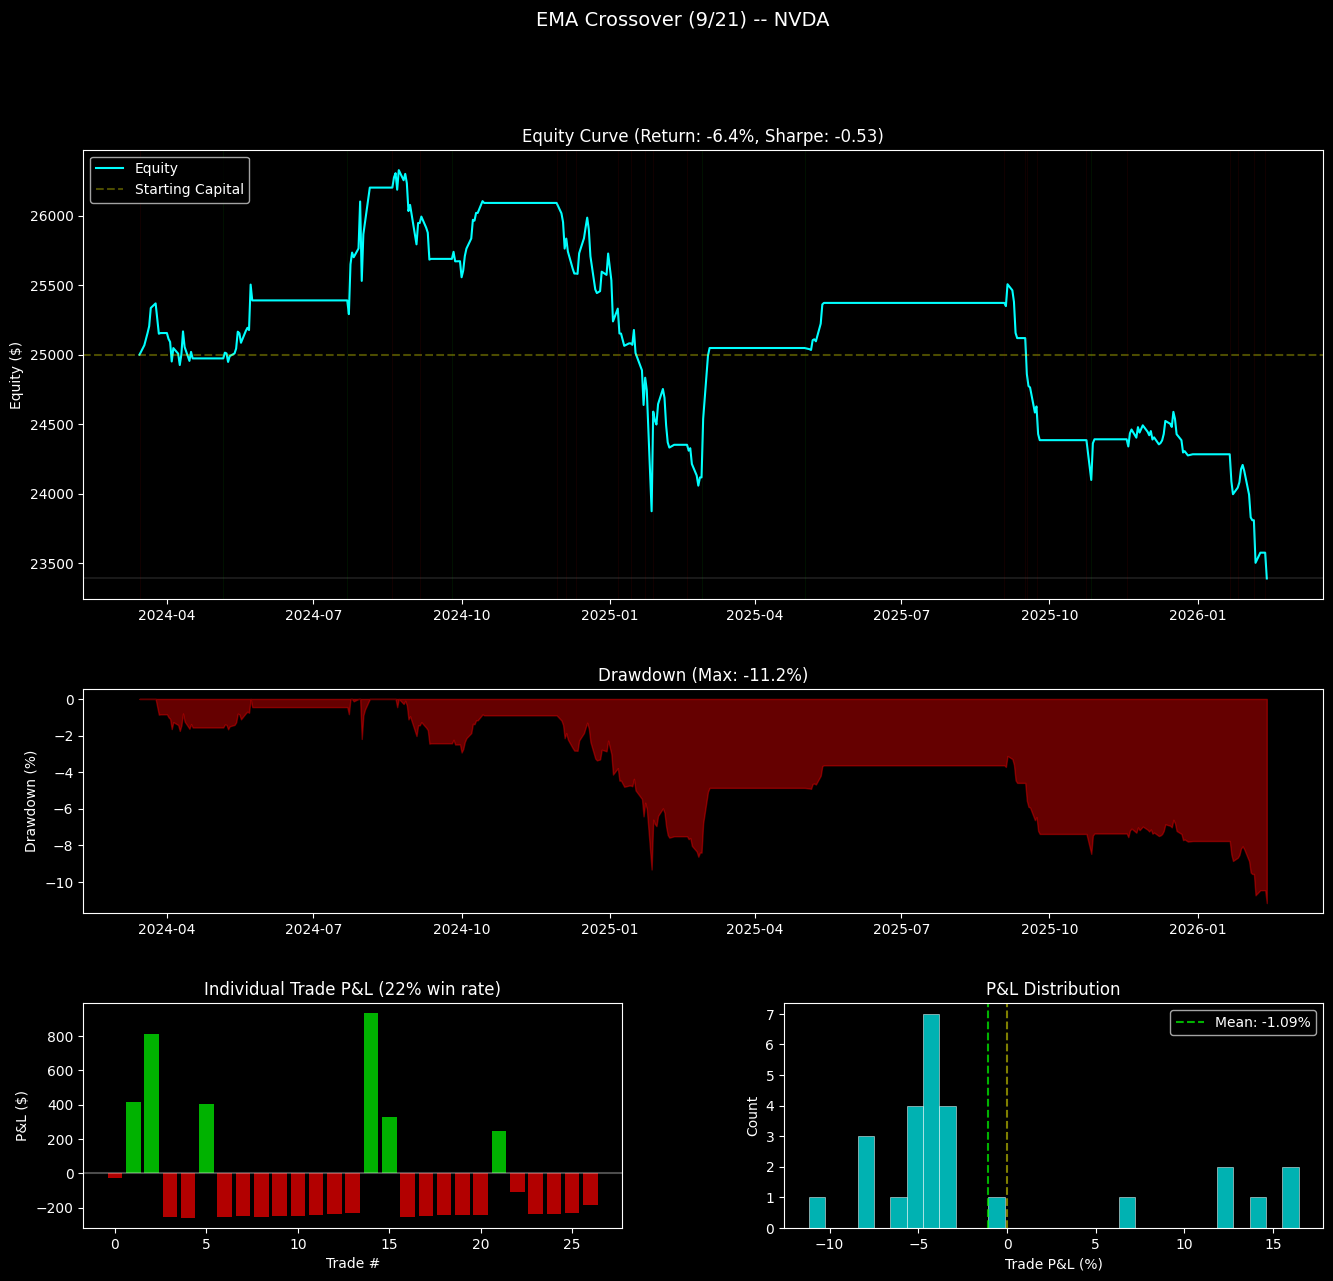

In [5]:
def prepare_ema_crossover(df, fast=9, slow=21, atr_period=14):
    """Add EMA crossover indicators to dataframe."""
    out = df.copy()
    out['EMA_Fast'] = EMAIndicator(df['Close'], window=fast).ema_indicator()
    out['EMA_Slow'] = EMAIndicator(df['Close'], window=slow).ema_indicator()
    out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=atr_period).average_true_range()
    out['EMA_Cross'] = (out['EMA_Fast'] > out['EMA_Slow']).astype(int)
    out['EMA_Cross_Prev'] = out['EMA_Cross'].shift(1)
    return out.dropna()


def strategy_ema_crossover(df, i, position):
    """EMA Crossover strategy signal generator."""
    row = df.iloc[i]
    atr = row['ATR']
    
    # Bullish crossover: fast EMA just crossed above slow EMA
    if row['EMA_Cross'] == 1 and row['EMA_Cross_Prev'] == 0:
        if position:  # close any short first
            return {'action': 'close'}
        if row['Close'] > row['EMA_Fast']:  # price confirming the uptrend
            return {
                'action': 'buy',
                'stop_loss': row['Close'] - 1.5 * atr,
                'take_profit': row['Close'] + 3.0 * atr,
            }
    
    # Bearish crossover: fast EMA just crossed below slow EMA
    elif row['EMA_Cross'] == 0 and row['EMA_Cross_Prev'] == 1:
        if position:  # close any long
            return {'action': 'close'}
        if row['Close'] < row['EMA_Fast']:  # price confirming downtrend
            return {
                'action': 'sell',
                'stop_loss': row['Close'] + 1.5 * atr,
                'take_profit': row['Close'] - 3.0 * atr,
            }
    
    return None


# Run backtest on NVDA
ticker = 'NVDA'
df_ema = prepare_ema_crossover(daily_data[ticker])
engine = BacktestEngine(initial_capital=25000, risk_per_trade_pct=1.0)
results_ema = engine.run(df_ema, strategy_ema_crossover)

print_metrics(results_ema['metrics'], f"EMA Crossover -- {ticker}")
plot_results(results_ema, "EMA Crossover (9/21)", ticker)

---
## 5. Strategy #2: RSI Mean Reversion

**The idea:** When RSI reaches extreme levels, the price has moved too far too fast
and is likely to "revert to the mean" (snap back).

- **Entry (Long):** RSI drops below 30 (oversold), then crosses back above 30
- **Entry (Short):** RSI rises above 70 (overbought), then crosses back below 70
- **Stop Loss:** 2x ATR from entry
- **Take Profit:** When RSI reaches 50 (mean), or 2x ATR
- **Filter:** Only trade in direction of larger trend (50 SMA)

In [6]:
def prepare_rsi_reversion(df, rsi_period=14, sma_period=50, atr_period=14):
    """Add RSI mean reversion indicators."""
    out = df.copy()
    out['RSI'] = RSIIndicator(df['Close'], window=rsi_period).rsi()
    out['SMA_50'] = SMAIndicator(df['Close'], window=sma_period).sma_indicator()
    out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=atr_period).average_true_range()
    out['RSI_Prev'] = out['RSI'].shift(1)
    return out.dropna()


def strategy_rsi_reversion(df, i, position):
    """RSI Mean Reversion strategy."""
    row = df.iloc[i]
    atr = row['ATR']
    rsi = row['RSI']
    rsi_prev = row['RSI_Prev']
    trend_up = row['Close'] > row['SMA_50']
    
    # Exit long when RSI reaches 50+ (mean reverted)
    if position and position.direction == 'long' and rsi > 50:
        return {'action': 'close'}
    
    # Exit short when RSI drops to 50- (mean reverted)
    if position and position.direction == 'short' and rsi < 50:
        return {'action': 'close'}
    
    if position:
        return None
    
    # Oversold bounce -- long entry
    # RSI was below 30 and just crossed back above (bounce starting)
    if rsi_prev < 30 and rsi >= 30 and trend_up:
        return {
            'action': 'buy',
            'stop_loss': row['Close'] - 2.0 * atr,
            'take_profit': row['Close'] + 2.0 * atr,
        }
    
    # Overbought reversal -- short entry
    # RSI was above 70 and just crossed back below (reversal starting)
    if rsi_prev > 70 and rsi <= 70 and not trend_up:
        return {
            'action': 'sell',
            'stop_loss': row['Close'] + 2.0 * atr,
            'take_profit': row['Close'] - 2.0 * atr,
        }
    
    return None


# Run backtest
ticker = 'NVDA'
df_rsi = prepare_rsi_reversion(daily_data[ticker])
results_rsi = engine.run(df_rsi, strategy_rsi_reversion)

print_metrics(results_rsi['metrics'], f"RSI Mean Reversion -- {ticker}")
plot_results(results_rsi, "RSI Mean Reversion (14)", ticker)


  RSI Mean Reversion -- NVDA -- Performance Summary
  No trades generated.
RSI Mean Reversion (14): No trades to plot.


---
## 6. Strategy #3: Bollinger Band Squeeze Breakout

**The idea:** When Bollinger Bands contract ("squeeze"), volatility is low and a big
move is coming. We trade the breakout when price exits the bands.

- **Squeeze detection:** Band width is in the lowest 20% of its recent range
- **Entry (Long):** Price closes above upper band after a squeeze
- **Entry (Short):** Price closes below lower band after a squeeze
- **Stop Loss:** Middle band (20 SMA)
- **Take Profit:** 2x the band width from entry


  BB Squeeze Breakout -- NVDA -- Performance Summary
  Total Trades:      3
  Winners/Losers:    1 / 2
  Win Rate:          33.3%
  Avg Win:           $   +426.89 (+28.89%)
  Avg Loss:          $   -201.25 (-8.96%)
  Largest Win:       $   +426.89
  Largest Loss:      $   -239.09
  ---
  Total P&L:         $    +24.39
  Total Return:           +0.10%
  Profit Factor:           1.06
  Sharpe Ratio:            0.07
  Max Drawdown:           -1.09%
  ---
  Avg Bars Held:           19.0
  Exits: Stop=1, TP=1, Signal=1

  Assessment:
  -> Marginal edge. Needs optimization or filtering.


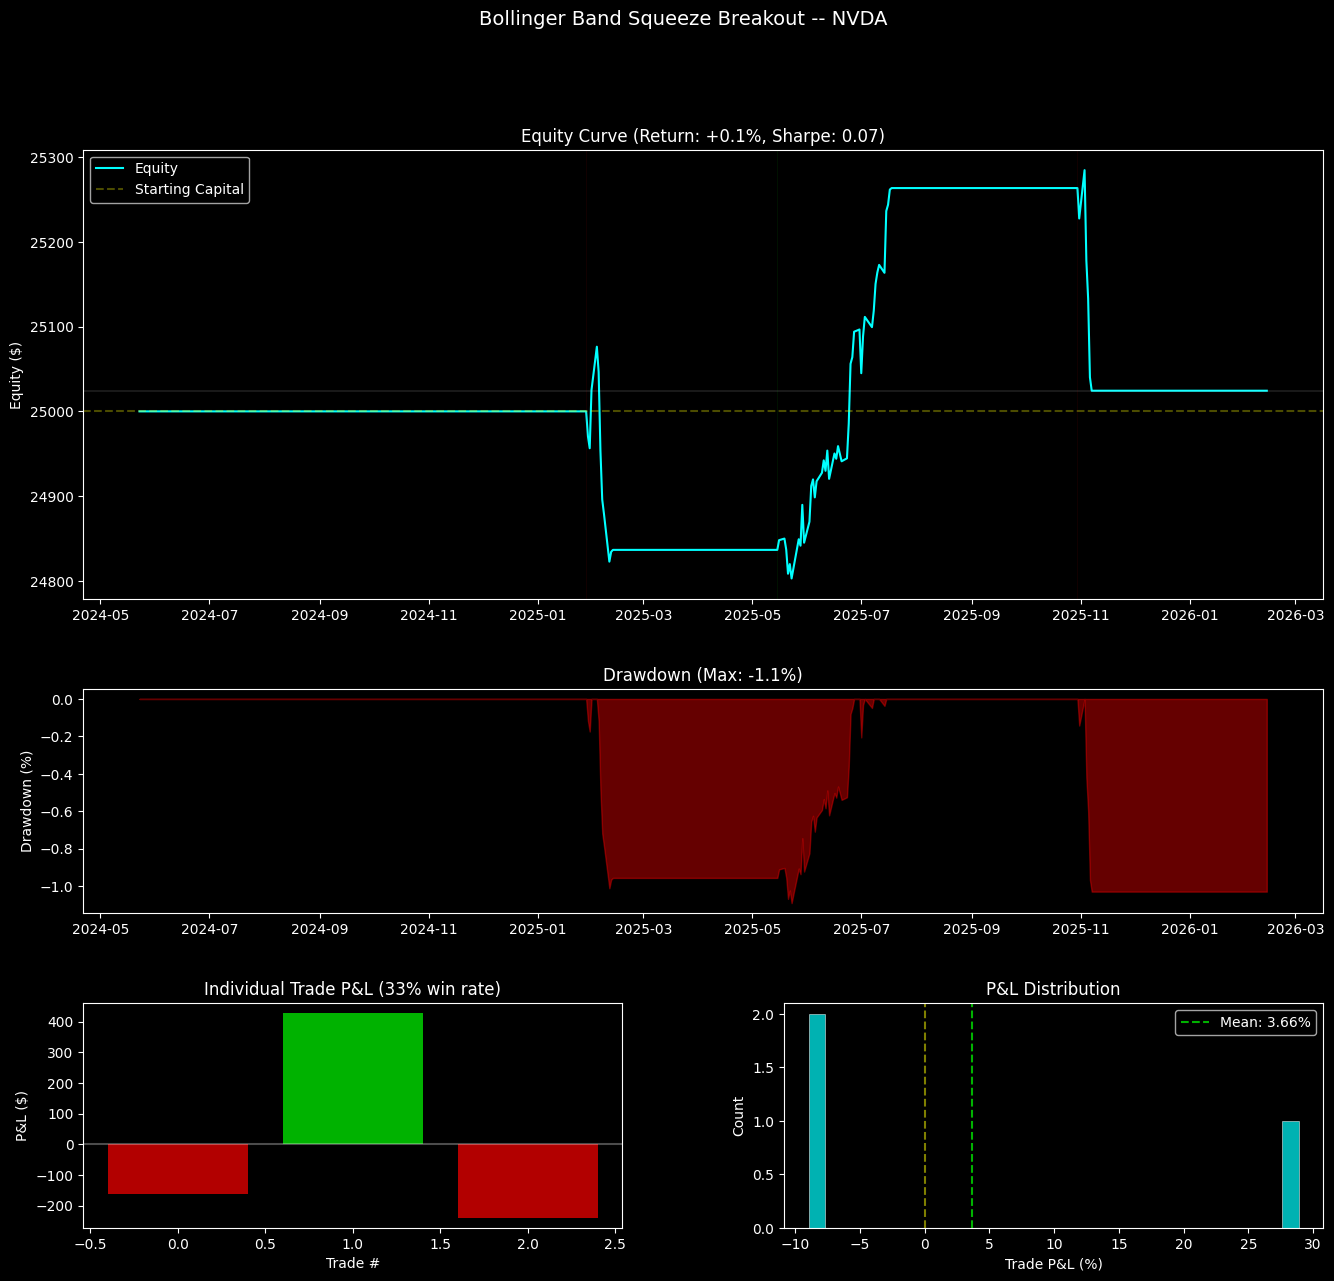

In [7]:
def prepare_bb_squeeze(df, bb_period=20, bb_std=2.0, atr_period=14, lookback=50):
    """Add Bollinger Band squeeze indicators."""
    out = df.copy()
    bb = BollingerBands(df['Close'], window=bb_period, window_dev=bb_std)
    out['BB_Upper'] = bb.bollinger_hband()
    out['BB_Lower'] = bb.bollinger_lband()
    out['BB_Middle'] = bb.bollinger_mavg()
    out['BB_Width'] = (out['BB_Upper'] - out['BB_Lower']) / out['BB_Middle']
    out['BB_Width_Pctile'] = out['BB_Width'].rolling(lookback).apply(
        lambda x: (x.iloc[-1] <= x).sum() / len(x) * 100
    )
    out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close'], window=atr_period).average_true_range()
    out['In_Squeeze'] = (out['BB_Width_Pctile'] < 20).astype(int)
    out['Was_In_Squeeze'] = out['In_Squeeze'].shift(1)
    return out.dropna()


def strategy_bb_squeeze(df, i, position):
    """Bollinger Band Squeeze Breakout strategy."""
    row = df.iloc[i]
    
    # Close position if price reverts to middle band
    if position:
        if position.direction == 'long' and row['Close'] < row['BB_Middle']:
            return {'action': 'close'}
        elif position.direction == 'short' and row['Close'] > row['BB_Middle']:
            return {'action': 'close'}
        return None
    
    # Need recent squeeze (was squeezing recently)
    if i < 5:
        return None
    recent_squeeze = any(df.iloc[i-5:i+1]['In_Squeeze'] == 1)
    if not recent_squeeze:
        return None
    
    band_width = row['BB_Upper'] - row['BB_Lower']
    
    # Breakout above upper band
    if row['Close'] > row['BB_Upper']:
        return {
            'action': 'buy',
            'stop_loss': row['BB_Middle'],
            'take_profit': row['Close'] + band_width,
        }
    
    # Breakout below lower band
    if row['Close'] < row['BB_Lower']:
        return {
            'action': 'sell',
            'stop_loss': row['BB_Middle'],
            'take_profit': row['Close'] - band_width,
        }
    
    return None


# Run backtest
ticker = 'NVDA'
df_bb = prepare_bb_squeeze(daily_data[ticker])
results_bb = engine.run(df_bb, strategy_bb_squeeze)

print_metrics(results_bb['metrics'], f"BB Squeeze Breakout -- {ticker}")
plot_results(results_bb, "Bollinger Band Squeeze Breakout", ticker)

---
## 7. Strategy #4: VWAP Bounce (Intraday)

**The idea:** VWAP (Volume-Weighted Average Price) is the most important intraday
level. Institutional traders use it as a benchmark. Price tends to bounce off VWAP.

- **Entry (Long):** Price pulls back to VWAP from above, touches/dips below, then reclaims it
- **Entry (Short):** Price rallies to VWAP from below, touches/pierces above, then rejects
- **Filter:** Only trade in the first 3 hours (most volume/reliability)
- **Stop Loss:** Low/High of the pullback candle
- **Take Profit:** 2x risk


  VWAP Bounce (Intraday) -- NVDA -- Performance Summary
  Total Trades:      46
  Winners/Losers:    15 / 31
  Win Rate:          32.6%
  Avg Win:           $   +158.18 (+0.67%)
  Avg Loss:          $    -77.92 (-0.33%)
  Largest Win:       $   +283.95
  Largest Loss:      $   -211.24
  ---
  Total P&L:         $    -42.75
  Total Return:           -0.17%
  Profit Factor:           0.98
  Sharpe Ratio:           -0.01
  Max Drawdown:           -3.28%
  ---
  Avg Bars Held:            7.3
  Exits: Stop=25, TP=13, Signal=8

  Assessment:
  -> Losing strategy. Needs rework or different parameters.


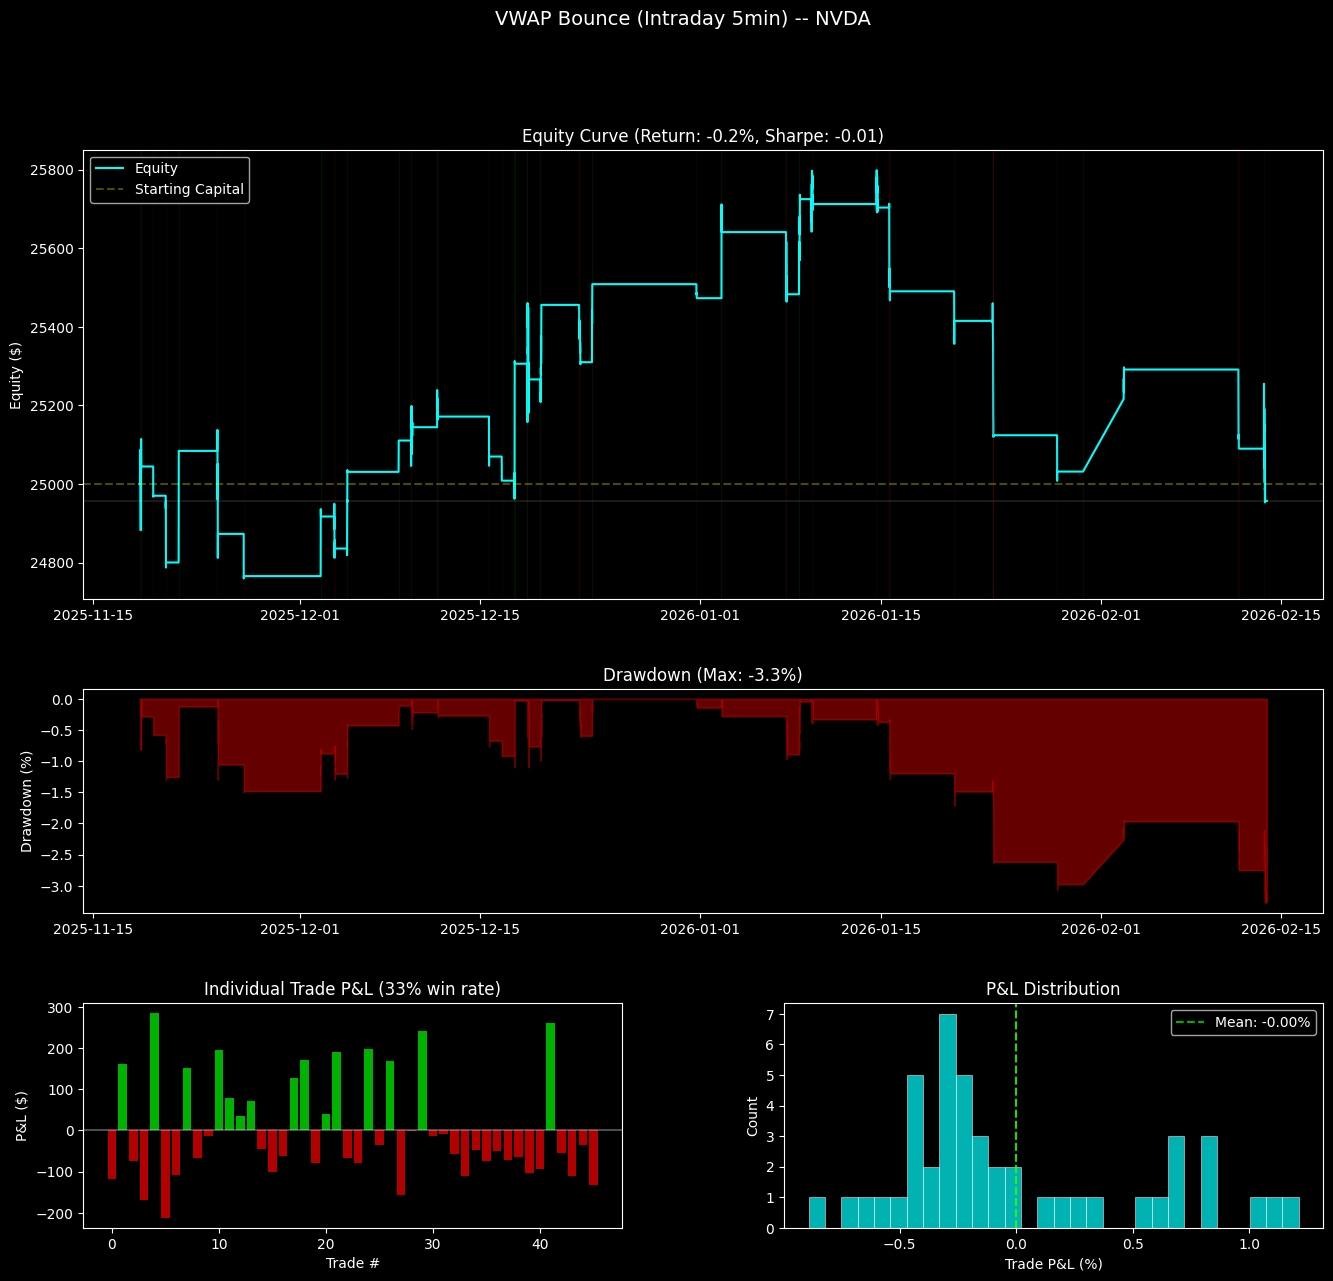

In [8]:
def prepare_vwap_bounce(df):
    """Add VWAP and related indicators for intraday data."""
    out = df.copy()
    
    # Calculate VWAP per day
    out['Date'] = out.index.date
    out['Cumulative_VP'] = out.groupby('Date')['Close'].transform(
        lambda x: (x * df.loc[x.index, 'Volume']).cumsum()
    )
    out['Cumulative_Vol'] = out.groupby('Date')['Volume'].cumsum()
    out['VWAP'] = out['Cumulative_VP'] / out['Cumulative_Vol']
    
    # Price relative to VWAP
    out['Above_VWAP'] = (out['Close'] > out['VWAP']).astype(int)
    out['Above_VWAP_Prev'] = out['Above_VWAP'].shift(1)
    
    # Distance from VWAP as % of price
    out['VWAP_Distance'] = (out['Close'] - out['VWAP']) / out['Close'] * 100
    
    # Bar number within day (for time filter)
    out['Bar_In_Day'] = out.groupby('Date').cumcount()
    
    out.drop(columns=['Cumulative_VP', 'Cumulative_Vol'], inplace=True)
    return out.dropna()


def strategy_vwap_bounce(df, i, position):
    """VWAP Bounce intraday strategy."""
    row = df.iloc[i]
    
    # Only trade first 36 bars (3 hours of 5-min bars)
    if row['Bar_In_Day'] > 36:
        if position:
            return {'action': 'close'}  # Close before end of active period
        return None
    
    # Skip first 6 bars (30 min for VWAP to stabilize)
    if row['Bar_In_Day'] < 6:
        return None
    
    if position:
        return None  # Let stop/TP handle exits
    
    # Long: price was above VWAP, dipped below, now reclaiming
    if row['Above_VWAP'] == 1 and row['Above_VWAP_Prev'] == 0:
        # Check that we were above VWAP recently (not a new downtrend)
        if i >= 6:
            recent_above = df.iloc[i-6:i]['Above_VWAP'].sum()
            if recent_above >= 3:  # Mostly above VWAP recently
                stop = row['Low']
                risk = row['Close'] - stop
                if risk > 0:
                    return {
                        'action': 'buy',
                        'stop_loss': stop,
                        'take_profit': row['Close'] + 2.0 * risk,
                    }
    
    # Short: price was below VWAP, popped above, now rejecting
    if row['Above_VWAP'] == 0 and row['Above_VWAP_Prev'] == 1:
        if i >= 6:
            recent_below = (df.iloc[i-6:i]['Above_VWAP'] == 0).sum()
            if recent_below >= 3:  # Mostly below VWAP
                stop = row['High']
                risk = stop - row['Close']
                if risk > 0:
                    return {
                        'action': 'sell',
                        'stop_loss': stop,
                        'take_profit': row['Close'] - 2.0 * risk,
                    }
    
    return None


# Run intraday backtest
ticker = 'NVDA'
if ticker in intraday_data and len(intraday_data[ticker]) > 100:
    df_vwap = prepare_vwap_bounce(intraday_data[ticker])
    results_vwap = engine.run(df_vwap, strategy_vwap_bounce)
    print_metrics(results_vwap['metrics'], f"VWAP Bounce (Intraday) -- {ticker}")
    plot_results(results_vwap, "VWAP Bounce (Intraday 5min)", ticker)
else:
    print(f"Insufficient intraday data for {ticker}. Using daily data demo instead.")
    results_vwap = {'trades': [], 'metrics': {'total_trades': 0}}

---
## 8. Strategy #5: Opening Range Breakout (ORB)

**The idea:** The first 15-30 minutes of trading establish a range. A breakout
above/below that range often leads to a trend for the rest of the day.

- **Opening range:** High and Low of the first 6 bars (30 min of 5-min candles)
- **Entry (Long):** Price breaks above the opening range high
- **Entry (Short):** Price breaks below the opening range low
- **Stop Loss:** Opposite end of the opening range
- **Take Profit:** 1.5x the opening range width


  Opening Range Breakout -- NVDA -- Performance Summary
  Total Trades:      95
  Winners/Losers:    29 / 66
  Win Rate:          30.5%
  Avg Win:           $    +87.46 (+0.72%)
  Avg Loss:          $    -81.81 (-0.74%)
  Largest Win:       $   +276.93
  Largest Loss:      $   -249.96
  ---
  Total P&L:         $  -2863.04
  Total Return:          -11.45%
  Profit Factor:           0.47
  Sharpe Ratio:           -0.54
  Max Drawdown:          -15.10%
  ---
  Avg Bars Held:           17.8
  Exits: Stop=5, TP=64, Signal=26

  Assessment:
  -> Losing strategy. Needs rework or different parameters.


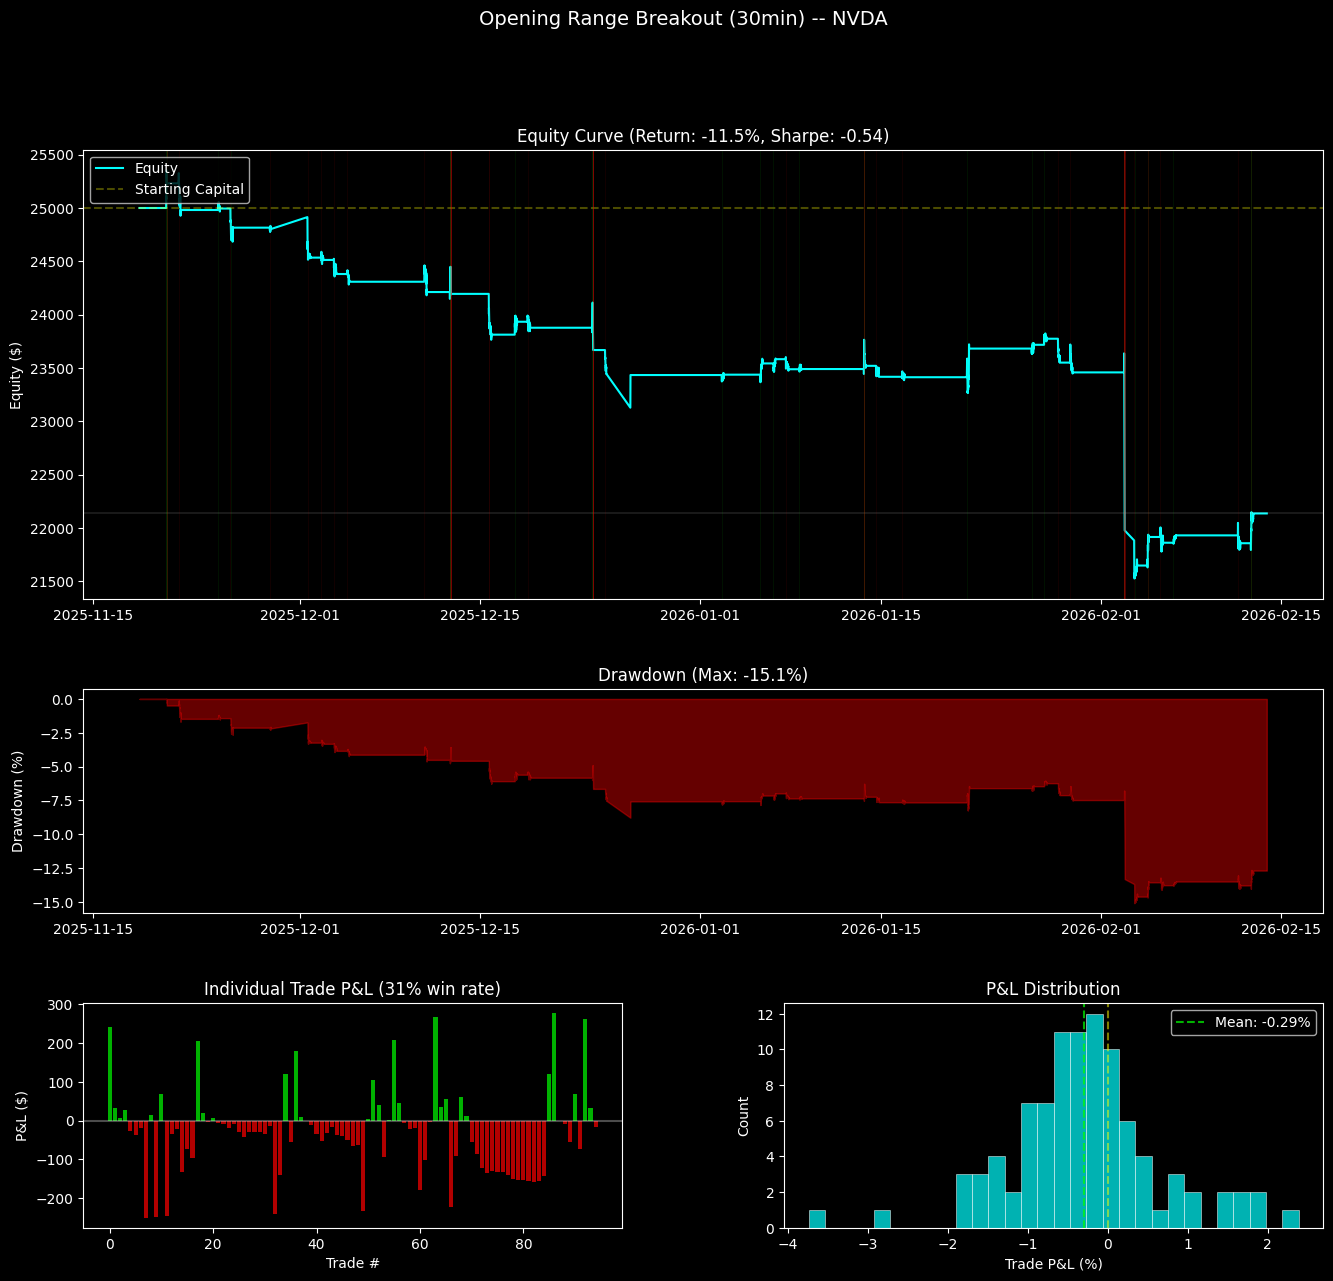

In [9]:
def prepare_orb(df, opening_bars=6):
    """Add Opening Range Breakout indicators to intraday data."""
    out = df.copy()
    out['Date'] = out.index.date
    out['Bar_In_Day'] = out.groupby('Date').cumcount()
    
    # Calculate opening range per day
    def calc_or(group):
        opening = group[group['Bar_In_Day'] < opening_bars]
        if len(opening) == 0:
            group['OR_High'] = np.nan
            group['OR_Low'] = np.nan
        else:
            group['OR_High'] = opening['High'].max()
            group['OR_Low'] = opening['Low'].min()
        return group
    
    out = out.groupby('Date', group_keys=False).apply(calc_or)
    out['OR_Width'] = out['OR_High'] - out['OR_Low']
    out['OR_Breakout_Up'] = (out['Close'] > out['OR_High']).astype(int)
    out['OR_Breakout_Down'] = (out['Close'] < out['OR_Low']).astype(int)
    
    return out.dropna()


def strategy_orb(df, i, position):
    """Opening Range Breakout strategy."""
    row = df.iloc[i]
    
    # Only trade after opening range is established
    if row['Bar_In_Day'] < 7:
        return None
    
    # Close positions in the last hour (bar ~66 of 78 total 5-min bars)
    if row['Bar_In_Day'] > 66:
        if position:
            return {'action': 'close'}
        return None
    
    # Only take one trade per day -- after first 2 hours (bar 24)
    if row['Bar_In_Day'] > 30:
        return None
    
    if position:
        return None  # Let stop/TP handle exits
    
    or_width = row['OR_Width']
    if or_width <= 0:
        return None
    
    # Breakout above opening range
    if row['Close'] > row['OR_High']:
        return {
            'action': 'buy',
            'stop_loss': row['OR_Low'],
            'take_profit': row['OR_High'] + 1.5 * or_width,
        }
    
    # Breakout below opening range
    if row['Close'] < row['OR_Low']:
        return {
            'action': 'sell',
            'stop_loss': row['OR_High'],
            'take_profit': row['OR_Low'] - 1.5 * or_width,
        }
    
    return None


# Run intraday backtest
ticker = 'NVDA'
if ticker in intraday_data and len(intraday_data[ticker]) > 100:
    df_orb = prepare_orb(intraday_data[ticker])
    results_orb = engine.run(df_orb, strategy_orb)
    print_metrics(results_orb['metrics'], f"Opening Range Breakout -- {ticker}")
    plot_results(results_orb, "Opening Range Breakout (30min)", ticker)
else:
    print(f"Insufficient intraday data for {ticker}.")
    results_orb = {'trades': [], 'metrics': {'total_trades': 0}}

---
## 9. Strategy Comparison Tournament

Run all strategies across multiple stocks and compare head-to-head.
This reveals which strategies work best in which market conditions.

In [10]:
# Run all daily strategies across multiple stocks
daily_strategies = {
    'EMA Crossover': (prepare_ema_crossover, strategy_ema_crossover),
    'RSI Reversion': (prepare_rsi_reversion, strategy_rsi_reversion),
    'BB Squeeze': (prepare_bb_squeeze, strategy_bb_squeeze),
}

test_tickers = ['NVDA', 'AAPL', 'TSLA', 'AMD', 'MSFT', 'META', 'SPY']
engine = BacktestEngine(initial_capital=25000, risk_per_trade_pct=1.0)

tournament_results = []

print("Running strategy tournament...\n")
for strat_name, (prepare_fn, strategy_fn) in daily_strategies.items():
    for ticker in test_tickers:
        try:
            df_prepared = prepare_fn(daily_data[ticker])
            result = engine.run(df_prepared, strategy_fn)
            m = result['metrics']
            
            tournament_results.append({
                'Strategy': strat_name,
                'Ticker': ticker,
                'Trades': m.get('total_trades', 0),
                'Win Rate %': m.get('win_rate', 0),
                'Total Return %': m.get('total_return_pct', 0),
                'Sharpe': m.get('sharpe_ratio', 0),
                'Max DD %': m.get('max_drawdown_pct', 0),
                'Profit Factor': m.get('profit_factor', 0),
                'Avg Trade $': m.get('avg_trade_pnl', 0),
            })
        except Exception as e:
            print(f"  Error: {strat_name} on {ticker}: {e}")

tournament_df = pd.DataFrame(tournament_results)
print("Tournament complete!\n")
tournament_df.round(2)

Running strategy tournament...

Tournament complete!



,Strategy,Ticker,Trades,Win Rate %,Total Return %,Sharpe,Max DD %,Profit Factor,Avg Trade $
0,EMA Crossover,NVDA,27,22.22,-6.44,-0.53,-11.16,0.66,-59.65
1,EMA Crossover,AAPL,17,35.29,1.35,0.20,-6.00,1.15,19.85
2,EMA Crossover,TSLA,21,19.05,-7.51,-0.92,-8.35,0.43,-89.42
3,EMA Crossover,AMD,17,41.18,5.60,0.69,-4.19,1.57,82.41
4,EMA Crossover,MSFT,17,47.06,7.65,0.84,-5.59,1.88,112.44
5,EMA Crossover,META,24,37.50,4.91,0.50,-4.90,1.38,51.15
6,EMA Crossover,SPY,18,27.78,-1.03,-0.06,-7.16,0.90,-14.81
7,RSI Reversion,NVDA,0,0.00,0.00,0.00,0.00,0.00,0.00
8,RSI Reversion,AAPL,0,0.00,0.00,0.00,0.00,0.00,0.00
9,RSI Reversion,TSLA,0,0.00,0.00,0.00,0.00,0.00,0.00


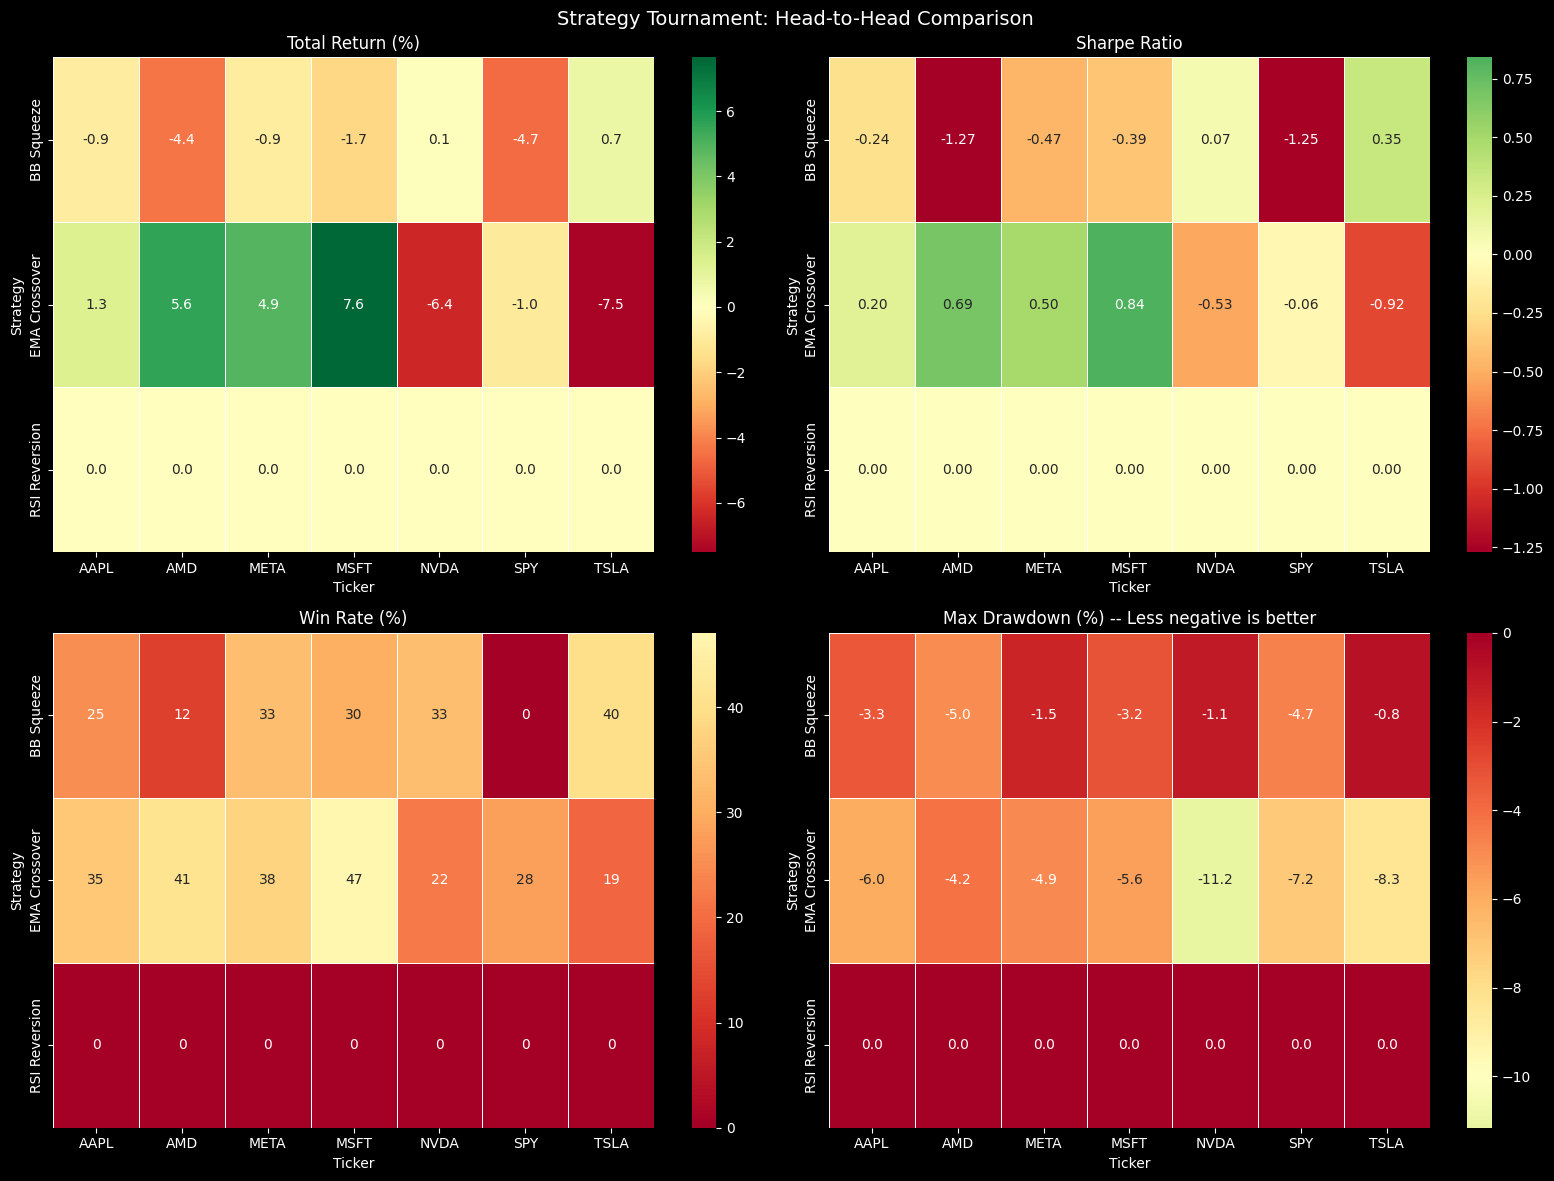

In [11]:
# Visualize tournament results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pivot for heatmaps
if len(tournament_df) > 0:
    # Total Return by strategy and ticker
    pivot_return = tournament_df.pivot(index='Strategy', columns='Ticker', values='Total Return %')
    sns.heatmap(pivot_return, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                ax=axes[0, 0], linewidths=0.5)
    axes[0, 0].set_title('Total Return (%)')

    # Sharpe Ratio
    pivot_sharpe = tournament_df.pivot(index='Strategy', columns='Ticker', values='Sharpe')
    sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                ax=axes[0, 1], linewidths=0.5)
    axes[0, 1].set_title('Sharpe Ratio')

    # Win Rate
    pivot_wr = tournament_df.pivot(index='Strategy', columns='Ticker', values='Win Rate %')
    sns.heatmap(pivot_wr, annot=True, fmt='.0f', cmap='RdYlGn', center=50,
                ax=axes[1, 0], linewidths=0.5)
    axes[1, 0].set_title('Win Rate (%)')

    # Max Drawdown
    pivot_dd = tournament_df.pivot(index='Strategy', columns='Ticker', values='Max DD %')
    sns.heatmap(pivot_dd, annot=True, fmt='.1f', cmap='RdYlGn_r', center=-10,
                ax=axes[1, 1], linewidths=0.5)
    axes[1, 1].set_title('Max Drawdown (%) -- Less negative is better')

plt.suptitle('Strategy Tournament: Head-to-Head Comparison', fontsize=14)
plt.tight_layout()
plt.show()

In [12]:
# Strategy rankings
if len(tournament_df) > 0:
    print("=== STRATEGY RANKINGS (Averaged Across All Stocks) ===\n")
    
    avg_by_strategy = tournament_df.groupby('Strategy').agg({
        'Trades': 'mean',
        'Win Rate %': 'mean',
        'Total Return %': 'mean',
        'Sharpe': 'mean',
        'Max DD %': 'mean',
        'Profit Factor': 'mean',
        'Avg Trade $': 'mean',
    }).round(2)
    
    # Rank by Sharpe ratio (best risk-adjusted measure)
    avg_by_strategy = avg_by_strategy.sort_values('Sharpe', ascending=False)
    print(avg_by_strategy.to_string())
    
    print(f"\nBest risk-adjusted strategy: {avg_by_strategy.index[0]}")
    print(f"Best total return strategy: {avg_by_strategy.sort_values('Total Return %', ascending=False).index[0]}")
    
    print("\n--- What This Tells Us ---")
    print("No single strategy wins everywhere. The best approach often combines multiple strategies")
    print("and adapts to current market conditions (trending vs ranging).")
    print("\nTrending markets:  Favor EMA Crossover, ORB")
    print("Ranging markets:   Favor RSI Reversion, BB Squeeze")

=== STRATEGY RANKINGS (Averaged Across All Stocks) ===

               Trades  Win Rate %  Total Return %  Sharpe  Max DD %  Profit Factor  Avg Trade $
Strategy                                                                                       
EMA Crossover   20.14       32.87            0.65    0.10     -6.76           1.14        14.57
RSI Reversion    0.00        0.00            0.00    0.00      0.00           0.00         0.00
BB Squeeze       6.71       24.88           -1.67   -0.46     -2.79           0.63       -51.81

Best risk-adjusted strategy: EMA Crossover
Best total return strategy: EMA Crossover

--- What This Tells Us ---
No single strategy wins everywhere. The best approach often combines multiple strategies
and adapts to current market conditions (trending vs ranging).

Trending markets:  Favor EMA Crossover, ORB
Ranging markets:   Favor RSI Reversion, BB Squeeze


---
## 10. Walk-Forward Analysis

**The right way to validate a strategy.**

Simple backtesting has a fatal flaw: you see ALL the data when developing the strategy,
so you unconsciously optimize for what already happened (overfitting).

Walk-forward analysis fixes this:
1. Train/optimize on a window of data ("in-sample")
2. Test on the NEXT unseen window ("out-of-sample")
3. Slide the window forward and repeat
4. Only out-of-sample results count

```
Time -->  [===TRAIN===][=TEST=]                       Window 1
               [===TRAIN===][=TEST=]                  Window 2
                    [===TRAIN===][=TEST=]             Window 3
                         [===TRAIN===][=TEST=]        Window 4
```

In [13]:
def walk_forward_analysis(df, prepare_fn, strategy_fn, 
                          train_days=252, test_days=63, step_days=63):
    """
    Walk-forward analysis: test a strategy on rolling out-of-sample windows.
    
    Parameters:
        df: Raw OHLCV DataFrame
        train_days: Number of days for training/optimization window (~1 year)
        test_days: Number of days for out-of-sample testing (~3 months)
        step_days: How far to slide the window each iteration (~3 months)
    """
    engine = BacktestEngine(initial_capital=25000, risk_per_trade_pct=1.0)
    all_oos_trades = []  # Out-of-sample trades only
    window_results = []
    
    total_days = len(df)
    start = 0
    window_num = 0
    
    while start + train_days + test_days <= total_days:
        window_num += 1
        
        # Define windows
        train_end = start + train_days
        test_end = train_end + test_days
        
        train_df = df.iloc[start:train_end]
        test_df = df.iloc[train_end:test_end]
        
        # Prepare test data with indicators (using enough history for indicators)
        # Use train+test data for indicator calculation, but only test period for signals
        combined = df.iloc[start:test_end]
        prepared = prepare_fn(combined)
        
        # Only test on the out-of-sample period
        oos_prepared = prepared[prepared.index >= test_df.index[0]]
        
        if len(oos_prepared) < 10:
            start += step_days
            continue
        
        # Run backtest on out-of-sample data
        result = engine.run(oos_prepared, strategy_fn)
        
        window_results.append({
            'window': window_num,
            'train_start': train_df.index[0].strftime('%Y-%m-%d'),
            'test_start': test_df.index[0].strftime('%Y-%m-%d'),
            'test_end': test_df.index[-1].strftime('%Y-%m-%d'),
            'trades': result['metrics'].get('total_trades', 0),
            'return_pct': result['metrics'].get('total_return_pct', 0),
            'sharpe': result['metrics'].get('sharpe_ratio', 0),
            'win_rate': result['metrics'].get('win_rate', 0),
            'max_dd': result['metrics'].get('max_drawdown_pct', 0),
        })
        
        all_oos_trades.extend(result['trades'])
        start += step_days
    
    return pd.DataFrame(window_results), all_oos_trades


# Run walk-forward on EMA Crossover with NVDA
print("Running Walk-Forward Analysis on EMA Crossover (NVDA)...\n")
wf_results, wf_trades = walk_forward_analysis(
    daily_data['NVDA'],
    prepare_ema_crossover,
    strategy_ema_crossover,
    train_days=200,
    test_days=60,
    step_days=60,
)

if len(wf_results) > 0:
    print("Out-of-Sample Results by Window:\n")
    print(wf_results.to_string(index=False))
    
    print(f"\n--- Walk-Forward Summary ---")
    print(f"  Windows tested: {len(wf_results)}")
    print(f"  Avg OOS return: {wf_results['return_pct'].mean():+.2f}%")
    print(f"  Avg OOS Sharpe: {wf_results['sharpe'].mean():.2f}")
    profitable_windows = (wf_results['return_pct'] > 0).sum()
    print(f"  Profitable windows: {profitable_windows} / {len(wf_results)} "
          f"({profitable_windows/len(wf_results)*100:.0f}%)")
    
    if wf_results['return_pct'].mean() > 0 and profitable_windows > len(wf_results) * 0.5:
        print(f"\n  Result: Strategy shows POSITIVE out-of-sample performance.")
        print(f"  This is much more trustworthy than a single backtest.")
    else:
        print(f"\n  Result: Strategy shows WEAK out-of-sample performance.")
        print(f"  The backtest results may have been overfitted.")
else:
    print("Not enough data for walk-forward analysis with these window sizes.")

Running Walk-Forward Analysis on EMA Crossover (NVDA)...

Out-of-Sample Results by Window:

 window train_start test_start   test_end  trades  return_pct    sharpe   win_rate    max_dd
      1  2024-02-14 2024-11-29 2025-02-27       8   -6.695023 -2.482655  12.500000 -8.168595
      2  2024-05-10 2025-02-28 2025-05-23       1    1.298136  3.399217 100.000000 -0.057446
      3  2024-08-07 2025-05-27 2025-08-20       0    0.000000  0.000000   0.000000  0.000000
      4  2024-10-31 2025-08-21 2025-11-13       6   -3.893534 -3.340391  16.666667 -5.502774
      5  2025-01-30 2025-11-14 2026-02-11       4   -3.382057 -3.101059   0.000000 -4.485809

--- Walk-Forward Summary ---
  Windows tested: 5
  Avg OOS return: -2.53%
  Avg OOS Sharpe: -1.10
  Profitable windows: 1 / 5 (20%)

  Result: Strategy shows WEAK out-of-sample performance.
  The backtest results may have been overfitted.


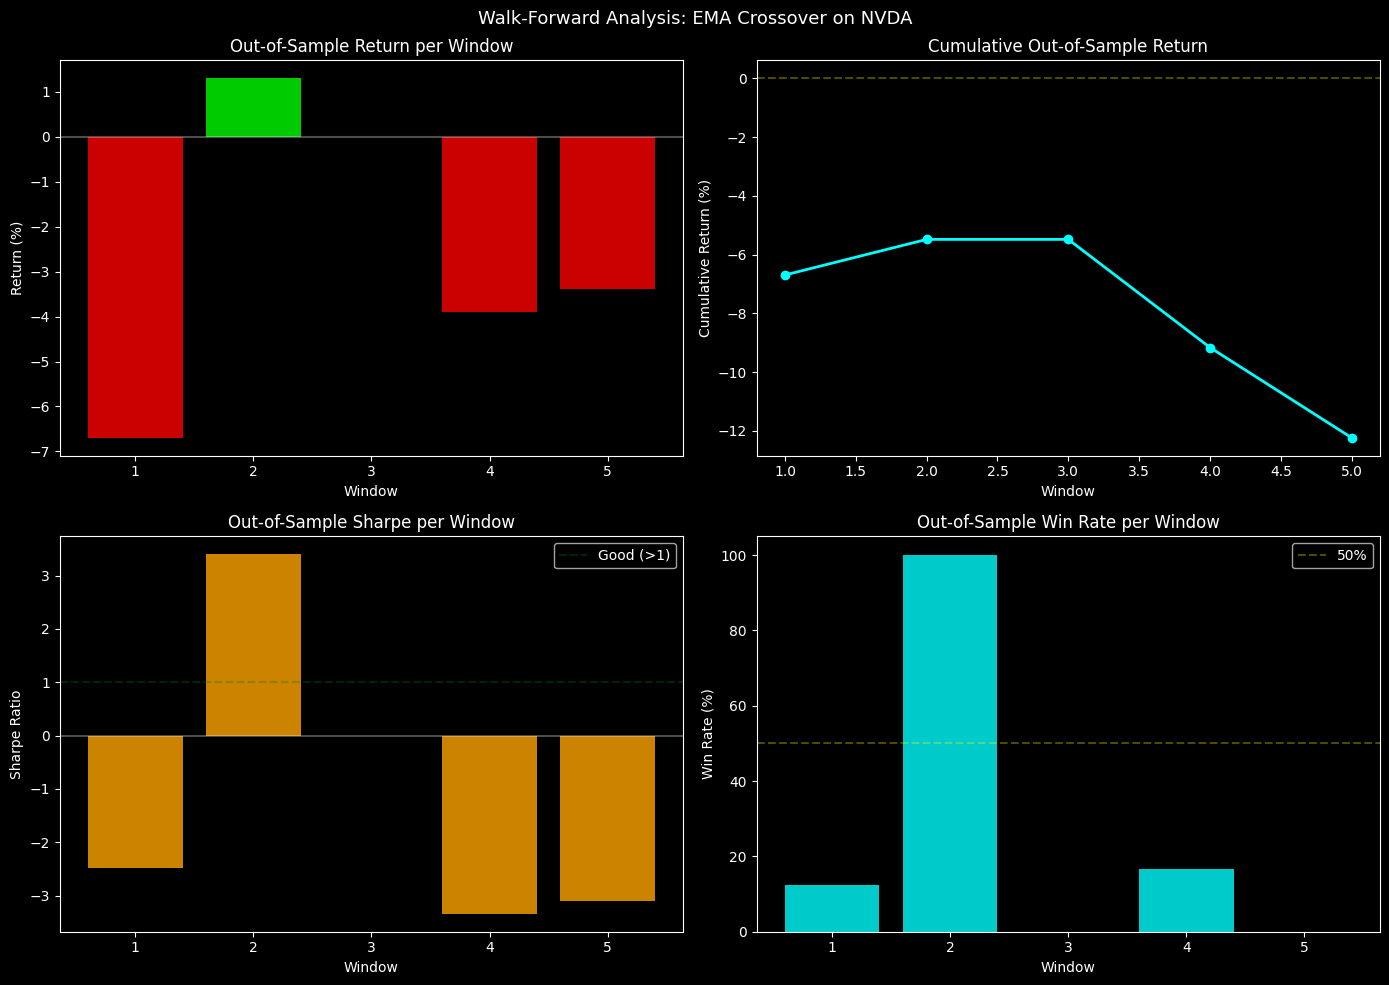

Consistent performance across windows = robust strategy
Erratic or declining performance = possible overfitting


In [14]:
# Visualize walk-forward results
if len(wf_results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Return per window
    colors = ['lime' if r > 0 else 'red' for r in wf_results['return_pct']]
    axes[0, 0].bar(wf_results['window'], wf_results['return_pct'], color=colors, alpha=0.8)
    axes[0, 0].axhline(y=0, color='white', alpha=0.3)
    axes[0, 0].set_xlabel('Window')
    axes[0, 0].set_ylabel('Return (%)')
    axes[0, 0].set_title('Out-of-Sample Return per Window')
    
    # Cumulative return
    cum_returns = (1 + wf_results['return_pct']/100).cumprod() * 100 - 100
    axes[0, 1].plot(wf_results['window'], cum_returns, color='cyan', marker='o', linewidth=2)
    axes[0, 1].axhline(y=0, color='yellow', linestyle='--', alpha=0.3)
    axes[0, 1].set_xlabel('Window')
    axes[0, 1].set_ylabel('Cumulative Return (%)')
    axes[0, 1].set_title('Cumulative Out-of-Sample Return')
    
    # Sharpe per window
    axes[1, 0].bar(wf_results['window'], wf_results['sharpe'], color='orange', alpha=0.8)
    axes[1, 0].axhline(y=0, color='white', alpha=0.3)
    axes[1, 0].axhline(y=1, color='green', linestyle='--', alpha=0.3, label='Good (>1)')
    axes[1, 0].set_xlabel('Window')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].set_title('Out-of-Sample Sharpe per Window')
    axes[1, 0].legend()
    
    # Win rate per window
    axes[1, 1].bar(wf_results['window'], wf_results['win_rate'], color='cyan', alpha=0.8)
    axes[1, 1].axhline(y=50, color='yellow', linestyle='--', alpha=0.3, label='50%')
    axes[1, 1].set_xlabel('Window')
    axes[1, 1].set_ylabel('Win Rate (%)')
    axes[1, 1].set_title('Out-of-Sample Win Rate per Window')
    axes[1, 1].legend()
    
    plt.suptitle('Walk-Forward Analysis: EMA Crossover on NVDA', fontsize=13)
    plt.tight_layout()
    plt.show()
    
    print("Consistent performance across windows = robust strategy")
    print("Erratic or declining performance = possible overfitting")

---
## 11. Parameter Sensitivity Analysis

How sensitive is the strategy to its parameters? If small changes destroy the
edge, the strategy is fragile (likely overfit). Robust strategies work across
a range of parameters.

Running parameter sensitivity analysis...


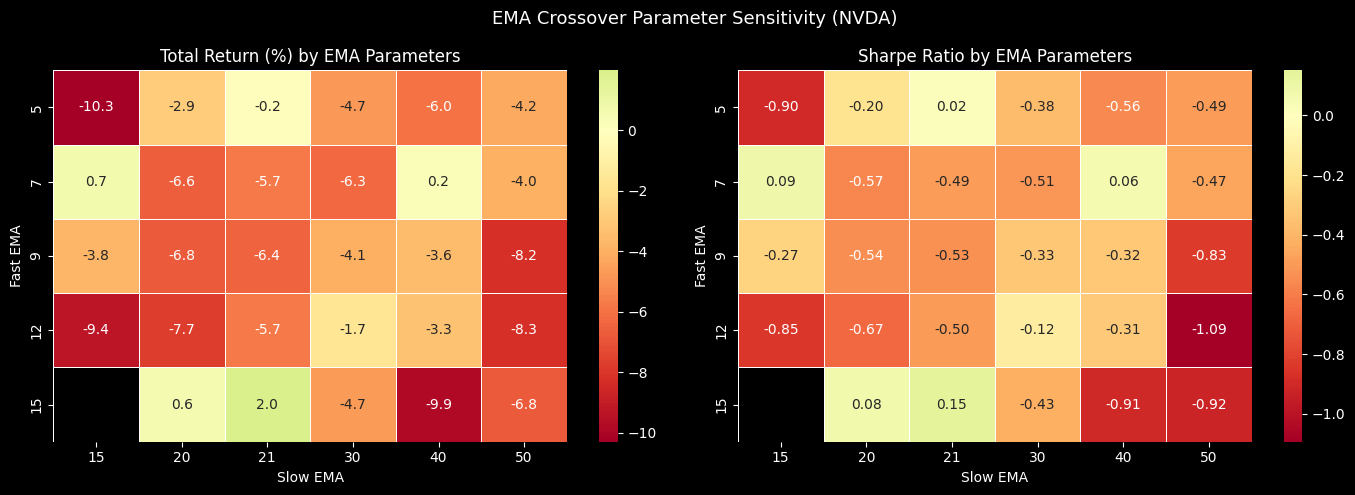

Profitable parameter combos: 4/29 (14%)
-> Strategy is FRAGILE -- only works with very specific parameters (likely overfit).

Best parameters: Fast=15, Slow=21
  Return: +2.0%, Sharpe: 0.15, Win Rate: 29%


In [15]:
# Parameter sweep for EMA Crossover
fast_periods = [5, 7, 9, 12, 15]
slow_periods = [15, 20, 21, 30, 40, 50]

param_results = []
print("Running parameter sensitivity analysis...")

for fast in fast_periods:
    for slow in slow_periods:
        if fast >= slow:  # fast must be less than slow
            continue
        try:
            df_test = prepare_ema_crossover(daily_data['NVDA'], fast=fast, slow=slow)
            result = engine.run(df_test, strategy_ema_crossover)
            m = result['metrics']
            param_results.append({
                'Fast EMA': fast,
                'Slow EMA': slow,
                'Return %': m.get('total_return_pct', 0),
                'Sharpe': m.get('sharpe_ratio', 0),
                'Trades': m.get('total_trades', 0),
                'Win Rate %': m.get('win_rate', 0),
                'Max DD %': m.get('max_drawdown_pct', 0),
            })
        except Exception:
            pass

param_df = pd.DataFrame(param_results)

if len(param_df) > 0:
    # Heatmap of returns by parameter combination
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    pivot_ret = param_df.pivot(index='Fast EMA', columns='Slow EMA', values='Return %')
    sns.heatmap(pivot_ret, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                ax=axes[0], linewidths=0.5)
    axes[0].set_title('Total Return (%) by EMA Parameters')
    
    pivot_sharpe = param_df.pivot(index='Fast EMA', columns='Slow EMA', values='Sharpe')
    sns.heatmap(pivot_sharpe, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
                ax=axes[1], linewidths=0.5)
    axes[1].set_title('Sharpe Ratio by EMA Parameters')
    
    plt.suptitle('EMA Crossover Parameter Sensitivity (NVDA)', fontsize=13)
    plt.tight_layout()
    plt.show()
    
    # Analysis
    positive_combos = (param_df['Return %'] > 0).sum()
    total_combos = len(param_df)
    print(f"Profitable parameter combos: {positive_combos}/{total_combos} ({positive_combos/total_combos*100:.0f}%)")
    
    if positive_combos > total_combos * 0.6:
        print("-> Strategy is ROBUST -- profitable across many parameter settings.")
    elif positive_combos > total_combos * 0.3:
        print("-> Strategy is MODERATE -- some parameter sensitivity.")
    else:
        print("-> Strategy is FRAGILE -- only works with very specific parameters (likely overfit).")
    
    best = param_df.sort_values('Sharpe', ascending=False).iloc[0]
    print(f"\nBest parameters: Fast={int(best['Fast EMA'])}, Slow={int(best['Slow EMA'])}")
    print(f"  Return: {best['Return %']:+.1f}%, Sharpe: {best['Sharpe']:.2f}, Win Rate: {best['Win Rate %']:.0f}%")

---
## 12. Common Pitfalls & Biases

Understanding these biases is **critical**. They're the difference between a strategy
that works on paper and one that works in reality.

### Biases That Will Fool You

| Bias | What It Is | How We Avoid It |
|------|-----------|------------------|
| **Look-Ahead Bias** | Using future data to make past decisions | Our engine enters on NEXT bar's open |
| **Overfitting** | Strategy tuned perfectly to past data but fails on new data | Walk-forward analysis, parameter sensitivity |
| **Survivorship Bias** | Only testing stocks that exist today (ignoring delisted ones) | Test on index ETFs (SPY/QQQ), be aware of this |
| **Data Snooping** | Testing many strategies and only reporting the best one | Pre-define strategy rules before testing |
| **Commission Neglect** | Ignoring the cost of trading | We include slippage + commissions |
| **Selection Bias** | Cherry-picking the test period that works best | Test across multiple time periods |
| **Regime Change** | Past market conditions may not repeat | Walk-forward analysis across different regimes |

### Red Flags in Backtest Results

- **Too good to be true**: >100% annual return with low drawdown = probably a bug
- **Very few trades**: <30 trades = statistically meaningless
- **Win rate > 80%**: Usually means stop losses are too wide (rare but huge losers)
- **Works on one stock only**: Not a strategy, it's a coincidence
- **Only works with exact parameters**: Fragile = overfit
- **All profits from 1-2 trades**: Lucky, not skilled

In [16]:
# Demonstrate overfitting with a cautionary example
# This "strategy" is designed to overfit -- it memorizes past data

def prepare_overfit_demo(df):
    out = df.copy()
    out['Return'] = out['Close'].pct_change()
    out['Future_Return'] = out['Return'].shift(-1)  # CHEATING: using future data!
    out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    return out.dropna()

def strategy_overfit_cheating(df, i, position):
    """INTENTIONALLY FLAWED: Uses future returns (look-ahead bias)."""
    row = df.iloc[i]
    if position:
        return None
    
    # This "predicts" perfectly because it literally looks at tomorrow's return
    if row['Future_Return'] > 0.01:  # Tomorrow goes up > 1%
        return {
            'action': 'buy',
            'stop_loss': row['Close'] * 0.98,
            'take_profit': row['Close'] * 1.05,
        }
    return None

# Show the "amazing" results of a cheating strategy
df_cheat = prepare_overfit_demo(daily_data['NVDA'])
results_cheat = engine.run(df_cheat, strategy_overfit_cheating)

print("=== CAUTIONARY EXAMPLE: Strategy with Look-Ahead Bias ===")
print("This strategy CHEATS by looking at tomorrow's return.")
print(f"\n  Return: {results_cheat['metrics'].get('total_return_pct', 0):+.1f}%")
print(f"  Win Rate: {results_cheat['metrics'].get('win_rate', 0):.1f}%")
print(f"  Sharpe: {results_cheat['metrics'].get('sharpe_ratio', 0):.2f}")

print("\nThese results look INCREDIBLE -- but they're completely fake.")
print("This is what overfitting looks like. If your results seem too good, they probably are.")
print("\nAlways ask: 'Could I have known this at the time of the trade?'")
print("If the answer is no, you have look-ahead bias.")

=== CAUTIONARY EXAMPLE: Strategy with Look-Ahead Bias ===
This strategy CHEATS by looking at tomorrow's return.

  Return: +269.8%
  Win Rate: 75.8%
  Sharpe: 3.60

These results look INCREDIBLE -- but they're completely fake.
This is what overfitting looks like. If your results seem too good, they probably are.

Always ask: 'Could I have known this at the time of the trade?'
If the answer is no, you have look-ahead bias.


---
## 13. Building Your Own Strategy -- Template

Use this template to implement and test your own strategies.

In [17]:
# === YOUR STRATEGY TEMPLATE ===
# Copy this cell and modify to create your own strategy

def prepare_my_strategy(df):
    """
    Add your indicators here.
    Return the DataFrame with all indicators calculated.
    """
    out = df.copy()
    
    # Add your indicators:
    out['EMA_9'] = EMAIndicator(df['Close'], window=9).ema_indicator()
    out['EMA_21'] = EMAIndicator(df['Close'], window=21).ema_indicator()
    out['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    out['ATR'] = AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
    
    # Add any derived features:
    out['Trend'] = (out['EMA_9'] > out['EMA_21']).astype(int)
    
    return out.dropna()


def my_strategy(df, i, position):
    """
    Your strategy logic.
    
    Parameters:
        df:       Full DataFrame with indicators
        i:        Current bar index (use df.iloc[i] to get current bar)
        position: Current position (None if flat, Position object if in trade)
    
    Returns:
        None:          No action
        {'action': 'buy', 'stop_loss': X, 'take_profit': Y}:   Enter long
        {'action': 'sell', 'stop_loss': X, 'take_profit': Y}:  Enter short
        {'action': 'close'}:                                     Close position
    """
    row = df.iloc[i]
    atr = row['ATR']
    
    # Define your exit rules first:
    if position:
        # Example: close long if trend changes
        if position.direction == 'long' and row['Trend'] == 0:
            return {'action': 'close'}
        return None
    
    # Define your entry rules:
    # Example: buy when trend is up AND RSI is not overbought
    if row['Trend'] == 1 and row['RSI'] < 60:
        return {
            'action': 'buy',
            'stop_loss': row['Close'] - 1.5 * atr,
            'take_profit': row['Close'] + 3.0 * atr,
        }
    
    return None


# Run your strategy:
# df_mine = prepare_my_strategy(daily_data['NVDA'])
# engine = BacktestEngine(initial_capital=25000, risk_per_trade_pct=1.0)
# results_mine = engine.run(df_mine, my_strategy, verbose=True)
# print_metrics(results_mine['metrics'], "My Strategy")
# plot_results(results_mine, "My Strategy", "NVDA")

print("Strategy template ready. Uncomment the code above to run it.")
print("\nSteps to develop your own strategy:")
print("  1. Define a clear hypothesis (why should this work?)")
print("  2. Write the entry/exit rules BEFORE looking at backtest results")
print("  3. Backtest on one stock to debug")
print("  4. Run across multiple stocks (tournament)")
print("  5. Walk-forward analysis to check for overfitting")
print("  6. Parameter sensitivity to check robustness")
print("  7. Paper trade for 1-3 months before going live")

Strategy template ready. Uncomment the code above to run it.

Steps to develop your own strategy:
  1. Define a clear hypothesis (why should this work?)
  2. Write the entry/exit rules BEFORE looking at backtest results
  3. Backtest on one stock to debug
  4. Run across multiple stocks (tournament)
  5. Walk-forward analysis to check for overfitting
  6. Parameter sensitivity to check robustness
  7. Paper trade for 1-3 months before going live


---
## 14. Summary & Key Lessons

### What We Built

| Component | Purpose |
|-----------|--------|
| **BacktestEngine** | Reusable, no-look-ahead backtesting with realistic fills |
| **5 Strategies** | EMA Crossover, RSI Reversion, BB Squeeze, VWAP Bounce, ORB |
| **Performance Metrics** | Sharpe, drawdown, profit factor, win rate, and more |
| **Tournament** | Head-to-head comparison across 7 stocks |
| **Walk-Forward Analysis** | Out-of-sample validation |
| **Parameter Sensitivity** | Robustness testing |
| **Strategy Template** | Starting point for your own strategies |

### The Most Important Lessons

1. **A strategy that hasn't been backtested is just a guess**
2. **Walk-forward results > single backtest results** (always)
3. **Robustness > optimization** -- a strategy that works "okay" across many settings
   is better than one that works "great" with exact parameters
4. **Risk management is more important than entry signals** -- the position sizing
   and stop loss rules matter more than when you enter
5. **No strategy works in all market conditions** -- know when your strategy fails
6. **Paper trade before live trading** -- always

### Realistic Expectations

| Metric | Excellent | Good | Mediocre |
|--------|-----------|------|-----------|
| Sharpe Ratio | > 2.0 | 1.0 - 2.0 | < 1.0 |
| Profit Factor | > 2.0 | 1.3 - 2.0 | < 1.3 |
| Max Drawdown | < 10% | 10-20% | > 20% |
| Win Rate (2:1 R/R) | > 45% | 35-45% | < 35% |

### Coming Up Next

**Notebook 04: Chronos Forecasting** -- Use Amazon's Chronos time series model
on your GPU for probabilistic price forecasting.

In [18]:
!nvidia-smi

Sat Feb 14 09:03:16 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:04:00.0 Off |                  Off |
|  0%   27C    P8             14W /  450W |      17MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----